In [190]:
# rerun if needed
# %pip install pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
data = pd.read_csv('teams.csv')
# all numeric columns
numeric_data = data.select_dtypes(include='number')
print(data.columns.tolist())

['team_id', 'team_name', 'season', 'league_id', 'team_form', 'games_played_home', 'games_played_away', 'wins_home', 'losses_home', 'draws_home', 'wins_away', 'losses_away', 'draws_away', 'stadium_capacity', 'team_country', 'goals_scored_0_15', 'goals_scored_16_30', 'goals_scored_31_45', 'goals_scored_46_60', 'goals_scored_61_75', 'goals_scored_76_90', 'goals_scored_91_105', 'goals_scored_106_120', 'goals_conceded_0_15', 'goals_conceded_16_30', 'goals_conceded_31_45', 'goals_conceded_46_60', 'goals_conceded_61_75', 'goals_conceded_76_90', 'goals_conceded_91_105', 'goals_conceded_106_120', 'clean_sheets', 'failed_to_score', 'penalty_success_rate', 'over_0_5', 'under_0_5', 'over_1_5', 'under_1_5', 'over_2_5', 'under_2_5', 'over_3_5', 'under_3_5', 'over_4_5', 'under_4_5', 'yellow_cards_0_15', 'yellow_cards_16_30', 'yellow_cards_31_45', 'yellow_cards_46_60', 'yellow_cards_61_75', 'yellow_cards_76_90', 'yellow_cards_91_105', 'yellow_cards_106_120', 'red_cards_0_15', 'red_cards_16_30', 'red_c

In [191]:
# Count the number of missing values in each column
missing_values = data.isnull().sum()
# Filter and print only the columns with missing values greater than zero
non_zero_missing = missing_values[missing_values > 0]
print(non_zero_missing)

team_form           206
team_country        666
lineups_per_game    666
dtype: int64


In [192]:
# after finding 206 null team_forms - we'll delte those rows - this teams weren't in the league at this season

updated_data = data.loc[~((data['games_played_home'] == 0) & 
                       (data['games_played_away'] == 0) & 
                       (data['wins_home'] == 0) & 
                       (data['losses_home'] == 0) & 
                       (data['draws_home'] == 0) & 
                       (data['wins_away'] == 0) & 
                       (data['losses_away'] == 0) & 
                       (data['draws_away'] == 0) & 
                       data['team_form'].isnull())]

# remove the column lineups_per_game - it includes at each fixture
updated_data = updated_data.drop(columns=['lineups_per_game'])

#checking
# Count the number of missing values in each column
missing_values = updated_data.isnull().sum()
# Filter and print only the columns with missing values greater than zero
non_zero_missing = missing_values[missing_values > 0]
print(non_zero_missing)




team_country    460
dtype: int64


In [193]:
# create dict for each league and it's country to fill team_country

team_country_dict = {39: 'England', 140:'Spain'}
updated_data['team_country'] = updated_data['league_id'].map(team_country_dict)

#checking
# Count the number of missing values in each column
missing_values = updated_data.isnull().sum()
# Filter and print only the columns with missing values greater than zero
non_zero_missing = missing_values[missing_values > 0]
print(non_zero_missing)


Series([], dtype: int64)


In [194]:
# check how many teams in each season
# Group by 'season' and count unique 'team_id'
team_count_per_season = updated_data.groupby('season')['team_id'].nunique()

# Print the result
print(team_count_per_season)

season
2010    20
2011    20
2012    20
2013    20
2014    20
2015    20
2016    20
2017    40
2018    40
2019    40
2020    40
2021    40
2022    40
2023    40
2024    40
Name: team_id, dtype: int64


Encode all the non numeric columns

In [195]:
# print all the non numeric columns
# Select columns that are non-numeric
non_numeric_data = updated_data.select_dtypes(exclude='number')

# Print the non-numeric data
print(non_numeric_data.columns.tolist())

# drop the column of team_name - we have team_id it's enough
# updated_data = updated_data.drop(columns=['team_name'])

# drop games_played_home  games_played_away - not relevant - all teams play the same amount of games + it will have good indicator on the fixtures table
# updated_data = updated_data.drop(columns=['games_played_home','games_played_away'])


['team_name', 'team_form', 'team_country']


In [196]:
# encode the team_country by get_dummies
dummies = pd.get_dummies(updated_data['team_country'], prefix='team_country')
#  include these dummy variables back into original DataFrame and drop the original column
updated_data = pd.concat([updated_data, dummies], axis=1)
updated_data.drop('team_country', axis=1, inplace=True)
# convert in into int and not true/false
dummy_cols = [col for col in updated_data.columns if any(prefix in col for prefix in ['team_country_'])]
updated_data[dummy_cols] = updated_data[dummy_cols].astype(int)

# To see the encoded DataFrame
print(updated_data.columns.tolist())


['team_id', 'team_name', 'season', 'league_id', 'team_form', 'games_played_home', 'games_played_away', 'wins_home', 'losses_home', 'draws_home', 'wins_away', 'losses_away', 'draws_away', 'stadium_capacity', 'goals_scored_0_15', 'goals_scored_16_30', 'goals_scored_31_45', 'goals_scored_46_60', 'goals_scored_61_75', 'goals_scored_76_90', 'goals_scored_91_105', 'goals_scored_106_120', 'goals_conceded_0_15', 'goals_conceded_16_30', 'goals_conceded_31_45', 'goals_conceded_46_60', 'goals_conceded_61_75', 'goals_conceded_76_90', 'goals_conceded_91_105', 'goals_conceded_106_120', 'clean_sheets', 'failed_to_score', 'penalty_success_rate', 'over_0_5', 'under_0_5', 'over_1_5', 'under_1_5', 'over_2_5', 'under_2_5', 'over_3_5', 'under_3_5', 'over_4_5', 'under_4_5', 'yellow_cards_0_15', 'yellow_cards_16_30', 'yellow_cards_31_45', 'yellow_cards_46_60', 'yellow_cards_61_75', 'yellow_cards_76_90', 'yellow_cards_91_105', 'yellow_cards_106_120', 'red_cards_0_15', 'red_cards_16_30', 'red_cards_31_45', 're

to deal with team form - we will convert each form to ternary num and then to decimal - L=0,D=1,W=2

In [197]:
# dict of LDW values
form_dict = {'L':0, 'D':1, 'W':3}

def process_team_form(row):
    # Replace each character in the string according to the dictionary
    form_numeric_string = ''.join(str(form_dict[char]) for char in row['team_form'])
    return int(form_numeric_string)  

updated_data_copy = updated_data.copy()

# Apply the function to the DataFrame
updated_data_copy['team_form_numeric'] = updated_data_copy.apply(process_team_form, axis=1)

# update it on the origin df
# Apply the function to the team_form column and create a new team_form_decimal column
updated_data['team_form_numeric'] = updated_data_copy[['team_form_numeric']]

# Drop the original team_form column
updated_data.drop('team_form', axis=1, inplace=True)

print(updated_data['team_form_numeric'])





0      10133133000100333013003331103103013330
2      30101313000330003300003313311033131130
3         10013013130300330013110113000303000
4        331103330310113333031330301330030133
5       3031033331331333130131131133333130013
                        ...                  
658    33100033303133130333333003313333301303
662    31133333330333333331310313130133031333
663    31003103101330000331131310011301003330
664    31303010110031003301000030111010300031
665    33100130303313133333331333333033031103
Name: team_form_numeric, Length: 460, dtype: object


normalize the integer values

In [198]:
print(updated_data.head())

# normalize stadium capacity with min-max - between 0-1 - not standartization cause I can't assume it normally distribute
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
min_max_scaler = MinMaxScaler()

# Fit and transform 'stadium_capacity'
updated_data['stadium_capacity_normalized'] = min_max_scaler.fit_transform(updated_data[['stadium_capacity']])

print(updated_data['stadium_capacity_normalized'])


   team_id          team_name  season  league_id  games_played_home  \
0       39             Wolves    2018         39                 19   
2       44            Burnley    2019         39                 19   
3       44            Burnley    2020         39                 19   
4       48           West Ham    2020         39                 19   
5       33  Manchester United    2020         39                 19   

   games_played_away  wins_home  losses_home  draws_home  wins_away  ...  \
0                 19         10            5           4          6  ...   
2                 19          8            7           4          7  ...   
3                 19          4            9           6          6  ...   
4                 19         10            5           4          9  ...   
5                 19          9            6           4         12  ...   

   red_cards_16_30  red_cards_31_45  red_cards_46_60  red_cards_61_75  \
0                1                0        

In [199]:
# add points for every 5 fixtures
def calculate_points(data):
    max_fixtures = 40
    for i in range(5, max_fixtures+1, 5):
        data[f'fixture_{i}_points'] = data['team_form_numeric'].apply(
            lambda x: sum(int(y) for y in str(x)[:i])
        )

    # Calculate the end season points, consider the length of the string for leagues with fewer than 40 fixtures
    data['end_season_points'] = data['team_form_numeric'].apply(
        lambda x: sum(int(y) for y in str(x))
    )

    # For leagues with fewer than 40 fixtures, copy the end_season_points to fixture_40_points
    data['fixture_40_points'] = data.apply(
        lambda row: row['end_season_points'] if 'fixture_40_points' not in row else row['fixture_40_points'],
        axis=1
    )

    return data

# Assuming updated_data is your DataFrame
updated_data = calculate_points(updated_data)
print(updated_data[['fixture_5_points', 'fixture_10_points', 'fixture_15_points', 'fixture_20_points', 'fixture_25_points', 'fixture_30_points', 'fixture_35_points', 'fixture_40_points', 'end_season_points']])


     fixture_5_points  fixture_10_points  fixture_15_points  \
0                   8                 15                 19   
2                   5                 12                 18   
3                   5                 13                 19   
4                   8                 20                 26   
5                   7                 20                 33   
..                ...                ...                ...   
658                 7                 16                 27   
662                11                 26                 38   
663                 7                 12                 19   
664                10                 13                 17   
665                 7                 14                 25   

     fixture_20_points  fixture_25_points  fixture_30_points  \
0                   29                 38                 44   
2                   24                 31                 39   
3                   26                 30          

In [200]:
# add "grades" columns for each 5 fixtures - the success rate
def add_success_rate(data):
    max_fixtures = 40
    # Add grades for each 5 fixtures
    for i in range(5, max_fixtures+1, 5):
        max_points = 3 * i
        column_name = f'fixture_{i}_points'
        grade_column = f'fixture_{i}_grade'
        if column_name in data.columns:
            data[grade_column] = data[column_name] / max_points

    # Calculate end of season grade
    data['end_season_grade'] = data['end_season_points'] / (3*(data['games_played_home'] + data['games_played_away']))

    return data

# Assuming updated_data is your DataFrame
updated_data = add_success_rate(updated_data)
print(updated_data[['fixture_5_grade', 'fixture_10_grade', 'fixture_15_grade', 'fixture_20_grade', 'fixture_25_grade', 'fixture_30_grade', 'fixture_35_grade', 'fixture_40_grade', 'end_season_grade']])


     fixture_5_grade  fixture_10_grade  fixture_15_grade  fixture_20_grade  \
0           0.533333          0.500000          0.422222          0.483333   
2           0.333333          0.400000          0.400000          0.400000   
3           0.333333          0.433333          0.422222          0.433333   
4           0.533333          0.666667          0.577778          0.633333   
5           0.466667          0.666667          0.733333          0.683333   
..               ...               ...               ...               ...   
658         0.466667          0.533333          0.600000          0.650000   
662         0.733333          0.866667          0.844444          0.850000   
663         0.466667          0.400000          0.422222          0.433333   
664         0.666667          0.433333          0.377778          0.400000   
665         0.466667          0.466667          0.555556          0.666667   

     fixture_25_grade  fixture_30_grade  fixture_35_grade  fixt

In [201]:
print(updated_data.head())

   team_id          team_name  season  league_id  games_played_home  \
0       39             Wolves    2018         39                 19   
2       44            Burnley    2019         39                 19   
3       44            Burnley    2020         39                 19   
4       48           West Ham    2020         39                 19   
5       33  Manchester United    2020         39                 19   

   games_played_away  wins_home  losses_home  draws_home  wins_away  ...  \
0                 19         10            5           4          6  ...   
2                 19          8            7           4          7  ...   
3                 19          4            9           6          6  ...   
4                 19         10            5           4          9  ...   
5                 19          9            6           4         12  ...   

   end_season_points  fixture_5_grade  fixture_10_grade  fixture_15_grade  \
0                 57         0.533333  

In [202]:
# Calculate the correlation matrix
correlation_matrix = updated_data.corr()

# Find pairs with a correlation greater than 0.7
high_corr_pairs = {}
for row in correlation_matrix.columns:
    for col in correlation_matrix.index:
        if row != col and abs(correlation_matrix.loc[row, col]) > 0.7:
            # Sort the row and column names to avoid duplicates like (A, B) and (B, A)
            sorted_pair = tuple(sorted((row, col)))
            high_corr_pairs[sorted_pair] = correlation_matrix.loc[row, col]

# Display high correlation pairs
for pair, corr_value in high_corr_pairs.items():
    print(f"{pair}: {corr_value:.2f}")

ValueError: could not convert string to float: 'Wolves'

In [184]:
print(updated_data.columns.tolist())

['team_id', 'season', 'league_id', 'games_played_home', 'games_played_away', 'wins_home', 'losses_home', 'draws_home', 'wins_away', 'losses_away', 'draws_away', 'stadium_capacity', 'goals_scored_0_15', 'goals_scored_16_30', 'goals_scored_31_45', 'goals_scored_46_60', 'goals_scored_61_75', 'goals_scored_76_90', 'goals_scored_91_105', 'goals_scored_106_120', 'goals_conceded_0_15', 'goals_conceded_16_30', 'goals_conceded_31_45', 'goals_conceded_46_60', 'goals_conceded_61_75', 'goals_conceded_76_90', 'goals_conceded_91_105', 'goals_conceded_106_120', 'clean_sheets', 'failed_to_score', 'penalty_success_rate', 'over_0_5', 'under_0_5', 'over_1_5', 'under_1_5', 'over_2_5', 'under_2_5', 'over_3_5', 'under_3_5', 'over_4_5', 'under_4_5', 'yellow_cards_0_15', 'yellow_cards_16_30', 'yellow_cards_31_45', 'yellow_cards_46_60', 'yellow_cards_61_75', 'yellow_cards_76_90', 'yellow_cards_91_105', 'yellow_cards_106_120', 'red_cards_0_15', 'red_cards_16_30', 'red_cards_31_45', 'red_cards_46_60', 'red_cards

KMeans algo

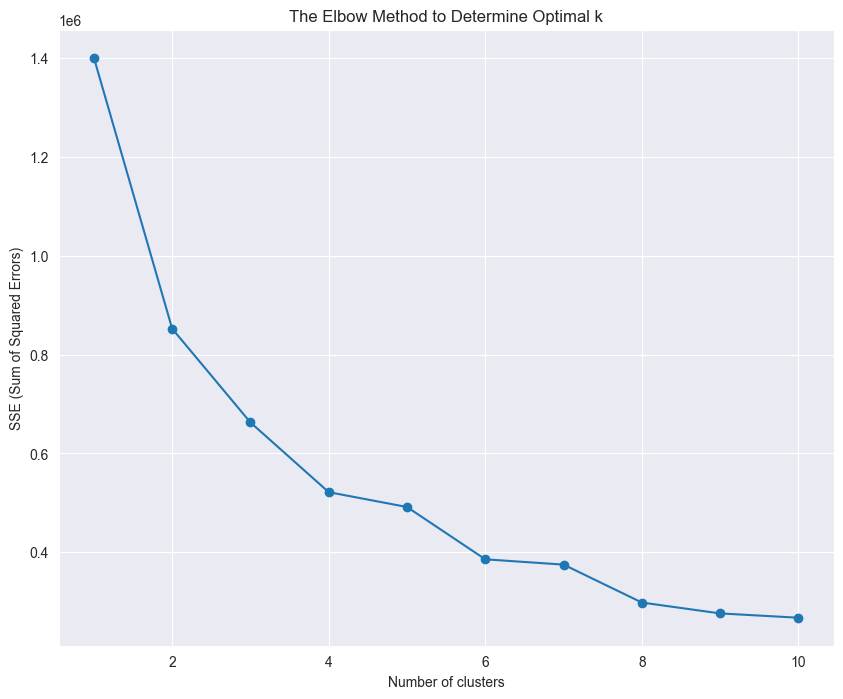

   Cluster  wins_home  losses_home  draws_home  wins_away  losses_away  \
0        0         10            5           4          6            8   
2        0          8            7           4          7            7   
3        0          4            9           6          6           10   
4        3         10            5           4          9            6   
5        3          9            6           4         12            0   

   draws_away  goals_scored_0_15  goals_scored_16_30  goals_scored_31_45  ...  \
0           5                  6                   8                   4  ...   
2           5                  6                   1                   7  ...   
3           3                  9                   5                   6  ...   
4           4                  9                  11                  11  ...   
5           7                  9                  10                   7  ...   

   end_season_points  fixture_5_grade  fixture_10_grade  fixture_15_

In [205]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Prepare the data
# Columns to exclude based on the above criteria
excluded_columns = ['team_id', 'team_name','season', 'league_id', 'stadium_capacity','games_played_home', 'games_played_away']

# Select the columns for clustering, ensuring they are numeric
columns_for_clustering = [col for col in updated_data.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns]

# Select data for clustering using the filtered columns
data_for_clustering = updated_data[columns_for_clustering]

# Step 2: Choosing the number of clusters
# Use the Elbow method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_for_clustering)  # Fit the original data directly
    sse.append(kmeans.inertia_)

# Plot SSE for each *k*
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('The Elbow Method to Determine Optimal k')
plt.show()

# Step 3: Apply K-means
# Choose the k after you find the elbow point from the plot, example value k_optimal might be 5 or as determined
k_optimal = 4 
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)  # Predict using the unnormalized data

# Add cluster labels to your original DataFrame
updated_data['Cluster'] = clusters

# Step 4: Analyze the Results
# Display the DataFrame with clusters
print(updated_data[['Cluster'] + columns_for_clustering].head())

# Optionally, analyze cluster centroids
# Note: Since no scaling was applied in this step, centroids are in the original scale
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=columns_for_clustering)
print(centroids)

print('*'*15)
# Group data by cluster
# Group data by cluster
cluster_groups = updated_data.groupby('Cluster')

# Print the teams and their seasons in each cluster
for cluster, data in cluster_groups:
    print(f"Cluster {cluster}:")
    # Create a list of tuples containing both 'team_name' and 'season'
    team_season_list = list(zip(data['team_name'], data['season']))
    print(team_season_list)
    print("\n")  # Adds a newline for better separation between clusters

    
print('*'*15)


Number of teams in each cluster:
Cluster
0    272
3    121
1     49
2     18
Name: count, dtype: int64


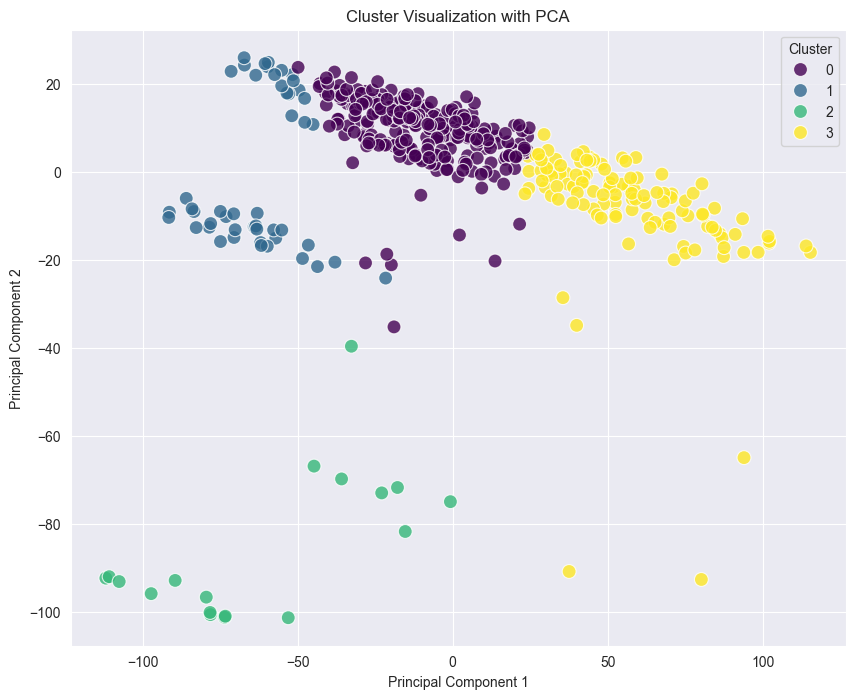

In [186]:
# plots to understand it better
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Count teams in each cluster
cluster_counts = updated_data['Cluster'].value_counts()
print("Number of teams in each cluster:")
print(cluster_counts)

# Dimensionality reduction for visualization (using PCA for 2D visualization)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_for_clustering)

# Create a scatter plot of the two PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=updated_data['Cluster'], palette='viridis', s=100, alpha=0.8)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


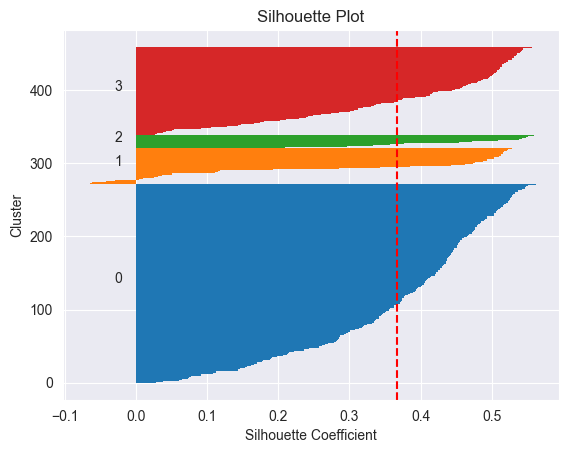

In [187]:
# Silhouette Plot
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate silhouette scores
silhouette_vals = silhouette_samples(data_for_clustering, clusters)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(range(k_optimal)):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(cluster))
    y_lower += len(cluster_silhouette_vals)

# The silhouette score gives a perspective into the density and separation of the formed clusters
plt.axvline(x=silhouette_score(data_for_clustering, clusters), color="red", linestyle="--")
plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.show()


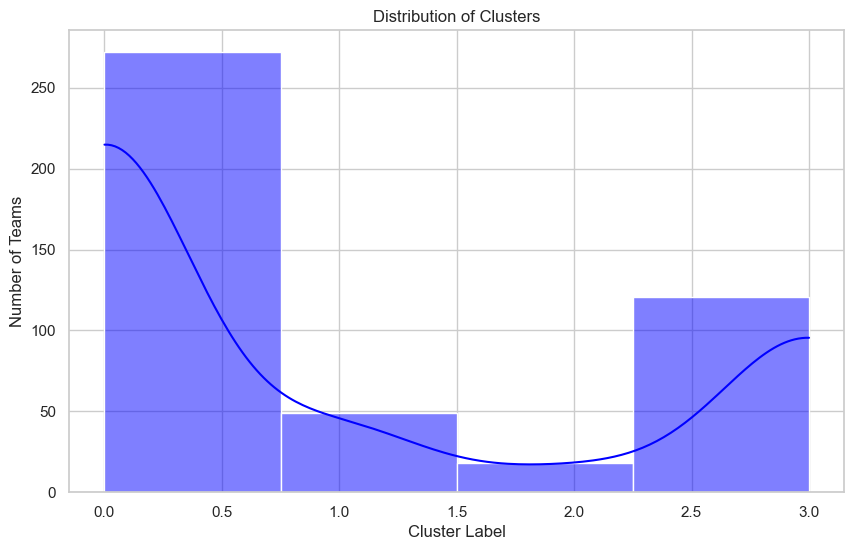

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a distribution plot of cluster labels
plt.figure(figsize=(10, 6))
sns.histplot(updated_data['Cluster'], kde=True, color="blue", bins=len(updated_data['Cluster'].unique()))
plt.title('Distribution of Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Teams')
plt.show()


DBScan algo

Number of teams in each cluster:
-1    460
Name: count, dtype: int64


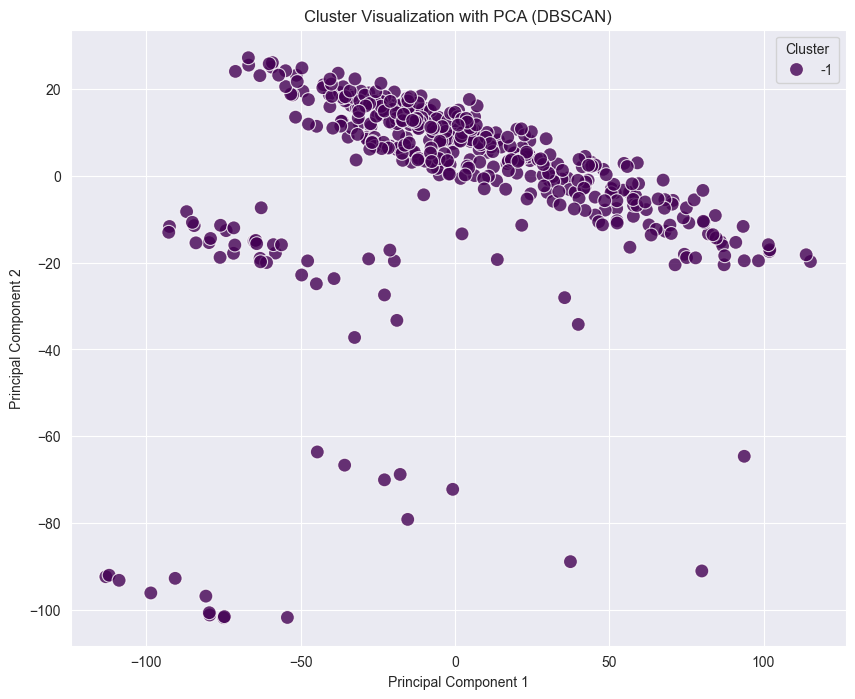

In [188]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming updated_data is your DataFrame

# Select only numeric columns for clustering
excluded_columns = ['team_id', 'season', 'league_id', 'stadium_capacity']
columns_for_clustering = [col for col in updated_data.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns]
data_for_clustering = updated_data[columns_for_clustering]

# Step 2: Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_for_clustering)

# Add cluster labels to your original DataFrame
updated_data['Cluster'] = clusters

# Step 3: Analyze the Results
# Count teams in each cluster
cluster_counts = pd.Series(clusters).value_counts()
print("Number of teams in each cluster:")
print(cluster_counts)

# Dimensionality reduction for visualization
pca = PCA(n_components=4)
data_pca = pca.fit_transform(data_for_clustering)

# Create a scatter plot of the two PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=updated_data['Cluster'], palette='viridis', s=100, alpha=0.8)
plt.title('Cluster Visualization with PCA (DBSCAN)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
